In [232]:
import multiprocessing
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from fairpair import *

### Distributions of Skill & Bias in Synthetic Datasets

In [372]:
def synthetic_variation(iteration:int, skill_scale: float, bias_loc: float) -> pd.DataFrame:
    G = FairPairGraph()
    G.generate_groups(400, 200)

    G.assign_skills(loc=0, scale=skill_scale) # assigns skills from a normal distribution
    G.assign_bias(nodes=G.unpriv_nodes, loc=bias_loc, scale=skill_scale/2) # assign bias

    sampling = RandomSampling(G)
    sampling.apply(iter = 500, k=1)

    ranker = RankRecovery(G)
    ranking,_ = ranker.apply() # by default, apply the RankCentrality recovery method

    base_scores = [skill for node, skill in G.nodes(data='skill')]

    return pd.DataFrame([
        {'iteration': iteration,
         'skill distr. variance': skill_scale,
         'bias distr. mean': bias_loc,
         'exposure difference': exposure_nodes(ranking, subgraph_nodes=G.unpriv_nodes) - exposure_nodes(ranking, subgraph_nodes=G.priv_nodes),
         'error': weighted_tau_nodes(base_scores, ranking, subgraph_nodes=list(G.nodes), complementary_nodes=[]),
         'error difference': weighted_tau_nodes(base_scores, ranking, subgraph_nodes=G.unpriv_nodes, complementary_nodes=G.priv_nodes) \
            - weighted_tau_nodes(base_scores, ranking, subgraph_nodes=G.priv_nodes, complementary_nodes=G.unpriv_nodes)}
    ])

def synthetic_starmap(args):
    return synthetic_variation(*args)

In [373]:
synthetic_starmap((1, 0.5, -0.5))

,iteration,skill distr. variance,bias distr. mean,exposure difference,error,error difference
0,1,0.5,-0.5,-0.017473,0.220197,0.019077


In [374]:
tasks = list(product(np.arange(10), np.linspace(0.1,2,20), np.linspace(0,-4,21))) # iteration, skill_scale, bias_loc

with multiprocessing.Pool() as pool:
    pbar = tqdm(pool.imap(synthetic_starmap, tasks), total=len(tasks))
    variations_df = pd.concat(pbar, ignore_index=True)

  0%|          | 0/4200 [00:00<?, ?it/s]

In [375]:
variations_df.to_csv('../fairpair/data/prelim_experiments/skill_bias_distr.csv', index=False)

In [489]:
plotting_df = variations_df.groupby(by=['skill distr. variance', 'bias distr. mean']).mean().drop(columns='iteration').reset_index()
plotting_df = plotting_df.melt(id_vars=['skill distr. variance', 'bias distr. mean'], var_name='metric')
#plotting_df = plotting_df.pivot(index=['metric', 'bias distr. mean'], columns='skill distr. variance', values='value').reset_index(level='metric')
plotting_df

,skill distr. variance,bias distr. mean,metric,value
0,0.1,-4.0,exposure difference,-0.052120
1,0.1,-3.8,exposure difference,-0.052120
2,0.1,-3.6,exposure difference,-0.052120
3,0.1,-3.4,exposure difference,-0.052120
4,0.1,-3.2,exposure difference,-0.052120
...,...,...,...,...
1255,2.0,-0.8,error difference,0.028051
1256,2.0,-0.6,error difference,0.033306
1257,2.0,-0.4,error difference,0.031367
1258,2.0,-0.2,error difference,0.034676


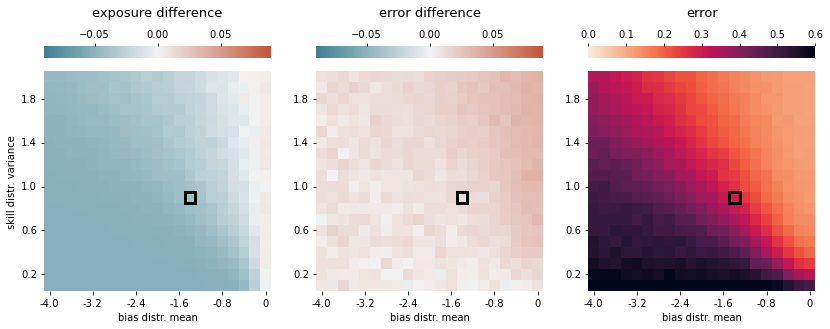

In [490]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    metric = data.metric.iloc[0]
    _df = data.pivot(index=args[1], columns=args[0], values=args[2])

    if metric == 'error':
        vmin = 0
        vmax = 0.6
        cmap = 'rocket_r'
        #cbar_ticks = [0,0.4,0.8]
    else: # exposure difference, error difference
        vmin = -0.09
        vmax = 0.09
        cmap = sns.diverging_palette(220, 20, as_cmap=True) #'crest'
        #cbar_ticks = [-0.4,-0.2,0,0.2,0.4]
    sns.heatmap(_df, vmin=vmin, vmax=vmax, cmap=cmap, cbar_kws = dict(location="top"), **kwargs)

g = sns.FacetGrid(plotting_df, col='metric',
                  col_order=['exposure difference', 'error difference', 'error'],
                  height=6,
                  aspect=0.72,
                  sharey=False)
g.map_dataframe(draw_heatmap, 'bias distr. mean', 'skill distr. variance', 'value')

g.figure.subplots_adjust(wspace=0.2)

for col_val, ax in g.axes_dict.items():
    ax.set_title(col_val, pad=55, fontdict={'fontsize': 13})
    ax.set_ylim(0,20)
    ax.set_yticks(np.arange(0.2,2.2,0.4)*10-0.5)
    ax.set_yticklabels(np.arange(0.2,2.2,0.4).round(1), rotation=0)
    ax.set_xlim(0,21)
    ax.set_xticks(np.arange(0,2.2,0.4)*10+0.5)
    ax.set_xticklabels(list(np.arange(-4,0,0.8).round(1)) + [0], rotation=0)

    # highlight the settings that we chose
    # sigma_skill = 0.86142674, myu_bias = -1.43574282
    ax.add_patch(Rectangle((13,8),1,1,fill=False, edgecolor='black', lw=3, clip_on=False))

plt.savefig('../fairpair/data/prelim_experiments/skill_bias_distr.pdf', bbox_inches="tight")

## Random Sampling: % selected, # iterations

In [378]:
def sampling_variation(trial:int, perc_selected:float, max_iterations:int, steps:int, start_at:int=50) -> pd.DataFrame:
    G = FairPairGraph()
    G.generate_groups(400, 200)

    G.assign_skills(loc=0, scale=0.86142674) # assigns skills from a normal distribution
    G.assign_bias(nodes=G.unpriv_nodes, loc=-1.43574282, scale=0.86142674 / 2) # assign bias

    sampling = RandomSampling(G)
    current_iteration = start_at # start at ~60 steps for a connected graph
    sampling.apply(iter=start_at, f=perc_selected, k=1)
    results = pd.DataFrame()

    while current_iteration <= max_iterations:
        sampling.apply(iter=steps, f=perc_selected, k=1)

        ranker = RankRecovery(G)
        try:
            ranking,_ = ranker.apply() # by default, apply the RankCentrality recovery method

            base_scores = [skill for node, skill in G.nodes(data='skill')]

            _df = pd.DataFrame([
                {'trial': trial,
                'percent selected': perc_selected,
                'iteration': current_iteration,
                'exposure difference': exposure_nodes(ranking, subgraph_nodes=G.unpriv_nodes) - exposure_nodes(ranking, subgraph_nodes=G.priv_nodes),
                'error': weighted_tau_nodes(base_scores, ranking, subgraph_nodes=list(G.nodes), complementary_nodes=[]),
                'error difference': weighted_tau_nodes(base_scores, ranking, subgraph_nodes=G.unpriv_nodes, complementary_nodes=G.priv_nodes) \
                    - weighted_tau_nodes(base_scores, ranking, subgraph_nodes=G.priv_nodes, complementary_nodes=G.unpriv_nodes)}
            ])
        except:
            _df = pd.DataFrame([
                {'trial': trial,
                'percent selected': perc_selected,
                'iteration': current_iteration,
                'exposure difference': np.NaN,
                'error': np.NaN,
                'error difference': np.NaN}
            ])
        results = pd.concat([results, _df], ignore_index=True)
        current_iteration += steps
    return results

def sampling_starmap(args):
    return sampling_variation(*args)

In [379]:
tasks = list(product(np.arange(10), np.linspace(0.1,1,19), [600], [20], [0])) # trials, perc_selected, max_iterations, steps, start_at

with multiprocessing.Pool() as pool:
    pbar = tqdm(pool.imap(sampling_starmap, tasks), total=len(tasks))
    sampling_df = pd.concat(pbar, ignore_index=True)

  0%|          | 0/190 [00:00<?, ?it/s]

In [380]:
sampling_df.to_csv('../fairpair/data/prelim_experiments/sampling_size_iter.csv', index=False)
sampling_df

,trial,percent selected,iteration,exposure difference,error,error difference
0,0,0.1,0,NaN,NaN,NaN
1,0,0.1,20,NaN,NaN,NaN
2,0,0.1,40,-0.032430,0.419683,0.004652
3,0,0.1,60,-0.034904,0.398024,0.019125
4,0,0.1,80,-0.036951,0.382067,0.018106
...,...,...,...,...,...,...
5885,9,1.0,520,-0.044542,0.312442,0.025531
5886,9,1.0,540,-0.044546,0.313124,0.025626
5887,9,1.0,560,-0.044515,0.311887,0.025566
5888,9,1.0,580,-0.044515,0.311205,0.025397


In [483]:
plotting_df = sampling_df.groupby(by=['percent selected', 'iteration']).mean().drop(columns='trial').reset_index()
plotting_df = plotting_df.melt(id_vars=['percent selected', 'iteration'], var_name='metric')
#plotting_df = plotting_df.pivot(index=['metric', 'bias distr. mean'], columns='skill distr. variance', values='value').reset_index(level='metric')
plotting_df

,percent selected,iteration,metric,value
0,0.1,0,exposure difference,NaN
1,0.1,20,exposure difference,NaN
2,0.1,40,exposure difference,-0.030598
3,0.1,60,exposure difference,-0.035510
4,0.1,80,exposure difference,-0.035959
...,...,...,...,...
1762,1.0,520,error difference,0.012390
1763,1.0,540,error difference,0.012362
1764,1.0,560,error difference,0.012431
1765,1.0,580,error difference,0.012398


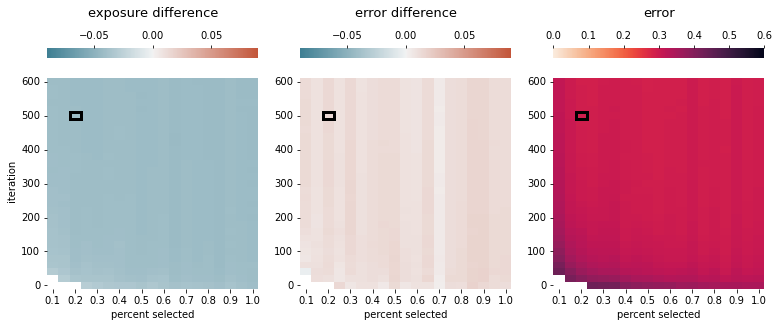

In [488]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    metric = data.metric.iloc[0]
    _df = data.pivot(index=args[1], columns=args[0], values=args[2])

    if metric == 'error':
        vmin = 0
        vmax = 0.6
        cmap = 'rocket_r'
        #cbar_ticks = [0,0.4,0.8]
    else: # exposure difference, error difference
        vmin = -0.09
        vmax = 0.09
        cmap = sns.diverging_palette(220, 20, as_cmap=True) #'crest'
        #cbar_ticks = [-0.4,-0.2,0,0.2,0.4]
    sns.heatmap(_df, cmap=cmap, vmin=vmin, vmax=vmax, cbar_kws = dict(location="top"), **kwargs)

g = sns.FacetGrid(plotting_df, col='metric',
                  col_order=['exposure difference', 'error difference', 'error'],
                  height=6,
                  aspect=0.6,
                  sharey=False)
g.map_dataframe(draw_heatmap, 'percent selected', 'iteration', 'value')

g.figure.subplots_adjust(wspace=0.2)

for col_val, ax in g.axes_dict.items():
    ax.set_title(col_val, pad=55, fontdict={'fontsize': 13})
    ax.set_ylim(0,32)
    ax.set_yticks(np.arange(0.5,31,5))
    ax.set_yticklabels(np.arange(0,610,100).round(1), rotation=0)
    ax.set_xlim(0,19)
    ax.set_xticks(np.arange(0.1,2.1,0.2)*10-0.5)
    ax.set_xticklabels(list(np.arange(0.1,1.1,0.1).round(1)), rotation=0)

    # highlight the settings that we chose
    # 500 iterations, 0.2 percent selected
    ax.add_patch(Rectangle((2,25),1,1,fill=False, edgecolor='black', lw=3, clip_on=False))

plt.savefig('../fairpair/data/prelim_experiments/sampling_size_iter.pdf', bbox_inches="tight")

## Oversampling: group ratio, oversampling ratio

In [383]:
def group_variation(trial:int, group_ratio:float, oversampling_ratio:float) -> pd.DataFrame:
    G = FairPairGraph()
    G.generate_groups(400, round(400*group_ratio))

    G.assign_skills(loc=0, scale=0.86142674) # assigns skills from a normal distribution
    G.assign_bias(nodes=G.unpriv_nodes, loc=-1.43574282, scale=0.86142674 / 2) # assign bias

    try:
        sampling = Oversampling(G)
        sampling.apply(iter=500, k=1, p=oversampling_ratio)
        
        ranker = RankRecovery(G)
        ranking,_ = ranker.apply() # by default, apply the RankCentrality recovery method

        base_scores = [skill for node, skill in G.nodes(data='skill')]

        return pd.DataFrame([
            {'trial': trial,
            'unpriv group ratio': group_ratio,
            'oversampling ratio': oversampling_ratio,
            'exposure difference': exposure_nodes(ranking, subgraph_nodes=G.unpriv_nodes) - exposure_nodes(ranking, subgraph_nodes=G.priv_nodes),
            'error': weighted_tau_nodes(base_scores, ranking, subgraph_nodes=list(G.nodes), complementary_nodes=[]),
            'error difference': weighted_tau_nodes(base_scores, ranking, subgraph_nodes=G.unpriv_nodes, complementary_nodes=G.priv_nodes) \
                - weighted_tau_nodes(base_scores, ranking, subgraph_nodes=G.priv_nodes, complementary_nodes=G.unpriv_nodes)}
        ])
    except:
        return pd.DataFrame([
            {'trial': trial,
            'unpriv group ratio': group_ratio,
            'oversampling ratio': oversampling_ratio,
            'exposure difference': np.NaN,
            'error': np.NaN,
            'error difference': np.NaN}
        ])

def group_starmap(args):
    return group_variation(*args)

In [388]:
tasks = list(product(np.arange(10), np.linspace(0.1,0.95,18), np.linspace(0.1,1,19))) # trials, group_ratio, oversampling_ratio

with multiprocessing.Pool() as pool:
    pbar = tqdm(pool.imap(group_starmap, tasks), total=len(tasks))
    group_df = pd.concat(pbar, ignore_index=True)

  0%|          | 0/3420 [00:00<?, ?it/s]

In [389]:
group_df.to_csv('../fairpair/data/prelim_experiments/oversampling_group_ratio.csv', index=False)
group_df

,trial,unpriv group ratio,oversampling ratio,exposure difference,error,error difference
0,0,0.10,0.10,-0.030901,0.186251,0.230392
1,0,0.10,0.15,-0.034075,0.193311,0.197745
2,0,0.10,0.20,-0.025691,0.232279,0.312140
3,0,0.10,0.25,0.012777,0.189843,0.213964
4,0,0.10,0.30,-0.032021,0.276802,0.402707
...,...,...,...,...,...,...
3415,9,0.95,0.80,-0.195618,0.233187,-0.259583
3416,9,0.95,0.85,-0.195712,0.223883,-0.336417
3417,9,0.95,0.90,-0.173786,0.219633,-0.286237
3418,9,0.95,0.95,-0.117230,0.208766,-0.167409


In [395]:
plotting_df = group_df.groupby(by=['unpriv group ratio', 'oversampling ratio']).mean().drop(columns='trial').reset_index()
plotting_df = plotting_df.melt(id_vars=['unpriv group ratio', 'oversampling ratio'], var_name='metric')
plotting_df = plotting_df.rename(columns={'oversampling ratio': 'sampling ratio', 'unpriv group ratio': 'unprivileged group ratio'})
#plotting_df = plotting_df.pivot(index=['metric', 'bias distr. mean'], columns='skill distr. variance', values='value').reset_index(level='metric')
plotting_df

,unprivileged group ratio,sampling ratio,metric,value
0,0.10,0.10,exposure difference,-0.027191
1,0.10,0.15,exposure difference,-0.027752
2,0.10,0.20,exposure difference,-0.021773
3,0.10,0.25,exposure difference,-0.010501
4,0.10,0.30,exposure difference,-0.016914
...,...,...,...,...
1021,0.95,0.80,error difference,-0.315783
1022,0.95,0.85,error difference,-0.279681
1023,0.95,0.90,error difference,-0.236515
1024,0.95,0.95,error difference,-0.189950


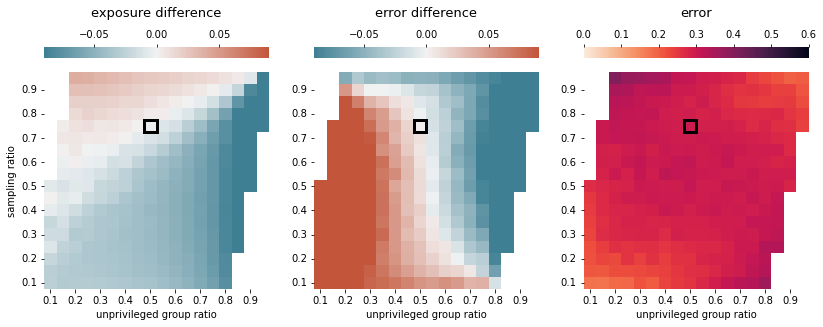

In [478]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    metric = data.metric.iloc[0]
    _df = data.pivot(index=args[1], columns=args[0], values=args[2])

    if metric == 'error':
        vmin = 0
        vmax = 0.6
        cmap = 'rocket_r'
        #cbar_ticks = [0,0.4,0.8]
    else: # exposure difference, error difference
        vmin = -0.09
        vmax = 0.09
        cmap = sns.diverging_palette(220, 20, as_cmap=True) #'crest'
        #cbar_ticks = [-0.4,-0.2,0,0.2,0.4]
    sns.heatmap(_df, cmap=cmap, vmin=vmin, vmax=vmax, cbar_kws = dict(location="top"), **kwargs)

g = sns.FacetGrid(plotting_df, col='metric',
                  col_order=['exposure difference', 'error difference', 'error'],
                  height=6,
                  aspect=0.72,
                  sharey=False)
g.map_dataframe(draw_heatmap, 'unprivileged group ratio', 'sampling ratio', 'value')

g.figure.subplots_adjust(wspace=0.2)

for col_val, ax in g.axes_dict.items():
    ax.set_title(col_val, pad=55, fontdict={'fontsize': 13})
    ax.set_ylim(0,18)
    ax.set_yticks(np.arange(0.5,18,2))
    ax.set_yticklabels(np.arange(0.1,1,.1).round(1), rotation=0)
    ax.set_xlim(0,18)
    ax.set_xticks(np.arange(0.5,18,2))
    ax.set_xticklabels(np.arange(0.1,1,.1).round(1), rotation=0)

    #y = 18
    #y_offset = 9
    #lim = 16.5 #-0.025 #-0.13 
    #inv_lim = 0 #0.025 #0.13
    #
    #if col_val == 'exposure difference':
    #    ax.annotate('Privileged group\nover-represented\nat top of ranking',
    #                xy=(lim, y), xytext=(lim,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small', rotation=90)
    #    ax.annotate('Unprivileged group\nover-represented\nat top of ranking',
    #                xy=(inv_lim, y), xytext=(inv_lim,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small', rotation=90)
    #elif col_val == 'error difference':
    #    ax.annotate('Privileged group\'s\nranks less accurately\nrecovered',
    #                xy=(lim, y), xytext=(lim,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small', rotation=90)
    #    ax.annotate('Unprivileged group\'s\nranks less accurately\nrecovered',
    #                xy=(inv_lim, y), xytext=(inv_lim,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small', rotation=90)
    #elif col_val == 'error':
    #    ax.annotate('Ranking closer to\nground truth',
    #                xy=(0.05, y), xytext=(-0.01,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small', rotation=90)
    #    ax.annotate('Ranking further away\nfrom ground truth',
    #                xy=(.85, y), xytext=(0.85,y+y_offset), horizontalalignment='left', verticalalignment='top', fontsize='x-small', rotation=90)

    # highlight the settings that we chose
    # unpriv ratio 0.5, sampling ratio 0.75
    ax.add_patch(Rectangle((8,13),1,1,fill=False, edgecolor='black', lw=3, clip_on=False))

plt.savefig('../fairpair/data/prelim_experiments/oversampling_group_ratio.pdf', bbox_inches="tight")